### NX-421: Neural signals and signal processing
# Miniproject 1 - Variant 3

### Camille Dorster, Toufan Kashaev, Johan Bordet

### Dataset description
The dataset used is a snippet issued from the Human Connectome Project. In particular, this task was adapted from a previously developed one by Buckner and colleagues (Buckner et al. 2011 [2]). Participants are shown visual cues asking them to either tap their left or right fingers, or squeeze their left or right toes, or move their tongue, the goal being to map motor areas. Each block of a movement type lasted ~12 seconds (10 movements), and is preceded by a ~3 second cue. In each of the two runs, there are 13 blocks, with 2 of tongue movements, 4 of hand movements (2 right and 2 left), and 4 of foot movements (2 right and 2 left). In addition, there are 3 15-second fixation blocks per run.

#### Importing the relevant libraries

In [1]:
import sys
import os

#####################
# Import of utils.py functions
#####################
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/data"

#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri
from nilearn.image import load_img, new_img_like, concat_imgs
from nilearn.masking import compute_epi_mask, apply_mask, unmask

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import matplotlib.pyplot as plt
import glob
import pandas as pd
import numpy as np
import json
import subprocess

# Utility function used to load json from file name
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

%gui wx

# ###################
# Preparing the paths and structure of the data in folders
###################

sample_path = "/home/jovyan/data"
deriv_path = "/home/jovyan/Labs/mydataset"
dataset_id = 'mydataset'
subject_id = '101410' 
subject_dir = 'sub-{}'.format(subject_id)

bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(deriv_path, 'derivatives','preprocessed_data')
preproc_subject_path = op.join(preproc_root, subject_dir)
preproc_anat_path = op.join(preproc_root, subject_dir, 'anat')
preproc_func_path = op.join(preproc_root, subject_dir, 'func')
preproc_fmap_path = op.join(preproc_root, subject_dir, 'fmap')
concat_tfMRI_data_path = op.join(preproc_func_path, 'sub-{}_task-motor_concat_scaled.nii.gz'.format(subject_id))
path_moco_data = op.join(preproc_func_path, 'sub-{}_tfMRI_MOTOR_LR_moco'.format(subject_id))
gaussian_filtered_path = op.join(preproc_func_path, 'sub-{}_task-motor_concat_bbr_smoothed-6mm.nii.gz'.format(subject_id))

###################
# Create folders relevant for preprocessing.
###################
mkdir_no_exist(sample_path)
mkdir_no_exist(bids_root)
mkdir_no_exist(deriv_root)
mkdir_no_exist(preproc_root)
mkdir_no_exist(preproc_subject_path)
mkdir_no_exist(preproc_anat_path)
mkdir_no_exist(preproc_func_path)
mkdir_no_exist(preproc_fmap_path)

Gtk-Message: 16:56:59.103: Failed to load module "canberra-gtk-module"


#### Starting FSLeyes

In [2]:
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

16:47:36: Debug: Adding duplicate image handler for 'Windows bitmap file'
16:47:36: Debug: Adding duplicate animation handler for '1' type
16:47:36: Debug: Adding duplicate animation handler for '2' type
16:47:36: Debug: Adding duplicate image handler for 'Windows bitmap file'
16:47:36: Debug: Adding duplicate animation handler for '1' type
16:47:36: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:14725): Gtk-CRITICAL **: 16:47:37.294: gtk_window_resize: assertion 'height > 0' failed


#### Printing project data directories

In [4]:
print_dir_tree(bids_root, max_depth=4)

|mydataset/
|--- .ipynb_checkpoints/
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|------------ fmap/
|------------ func/
|--- sub-101410/
|------ anat/
|--------- sub-101410_T1w.nii.gz
|------ func/
|--------- combined_events.csv
|--------- combined_events.tsv
|--------- events_LR.csv
|--------- events_RL.csv
|--------- sub-101410_tfMRI_MOTOR_LR.nii
|--------- sub-101410_tfMRI_MOTOR_RL.nii
|--------- task-motor_bold.json
|--------- .ipynb_checkpoints/
|------------ task-motor_bold-checkpoint.json


# Practicals part 1 - fMRI data preprocessing and GLM analysis


<table>
    <tr><th style='text-align:justify;'>Data type</th><th style='text-align:justify;'>Step name </th><th style='text-align:justify;'>Details of the step</th><th style='text-align:justify;'>FSL tool </th></tr>
    <tr><th>Anatomical</th><td></td><td></td></tr>
    <tr><td></td><td style='text-align:justify;'>1.a : Skull stripping</td><td style='text-align:justify;'>Removing skull and surrounding tissues to keep only the brain</td><td style='text-align:justify;'>BET</td></tr>
    <tr><td></td><td style='text-align:justify;'>1.b : Segmentation</td><td style='text-align:justify;'>Segmenting brain tissues based on their contrasts</td><td style='text-align:justify;'>FAST</td></tr>
    <tr><th>Functional</th><th></th><th></th></tr>
    <tr><td></td><td style='text-align:left;'>2.b Motion correction</td><td style='text-align:justify;'>Realignment of fMRI volumes to a common reference - typically one volume or the average of the volumes - to correct for inter-volume motion. The extracted motion parameters can be used for subsequent analysis (see GLM next week!)</td><td style='text-align:justify;'>MCFLIRT (which is one suboption of FLIRT in fact)</td></tr>
    <tr><td></td><td style='text-align:left;'>2.c (Bonus) Coregistration to anatomical</td><td style='text-align:justify;'>Putting the functional volumes in anatomical space</td><td style='text-align:justify;'>FLIRT (epi_reg being a specialized instance)</td></tr>
    <tr><td></td><td style='text-align:left;'>2.d Gaussian smoothing</td><td style='text-align:justify;'>Allowing a bit of lee-way in the voxel's values to account for the imperfection of the registration</td><td style='text-align:justify;'>fslmath with smoothing operation</td></tr>
</table>

## 1.a : Skull stripping

#### Applying BET to get the betted brain mask

In [5]:
resulting_mask_path = op.join(preproc_anat_path, 'sub-{}_T1w_mask'.format(subject_id))
anatomical_path = op.join(bids_root, subject_dir, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
betted_brain_path = op.join(preproc_anat_path, 'sub-{}_T1w'.format(subject_id))

os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R')) # Robust parameter used

print("Done with BET.")

Done with BET.


#### Displaying the mask

In [6]:
fsleyesDisplay.load(resulting_mask_path)

#### Applying the betted brain mask to the original brain

In [7]:
anatomical_path = op.join(bids_root, subject_dir, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id)) # The original brain
betted_brain_path = op.join(preproc_anat_path, 'sub-{}_T1w.nii.gz'.format(subject_id)) # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_anat_path, 'sub-{}_T1w_mask'.format(subject_id)) # The mask to use

os.system('fslmaths {} -mas {} {}'.format(anatomical_path, resulting_mask_path, betted_brain_path))

print("Mask applied.")

Mask applied.


#### Displaying the betted brain

In [8]:
# Display the betted brain
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)


(ipykernel_launcher.py:4596): Gdk-WARNING **: 20:36:48.210: gdkdrawable-x11.c:952 drawable is not a pixmap or window


## 1.b : Tissue segmentation

#### Applying segmentation to the betted brain

In [9]:
fast_target = betted_brain_path

[os.remove(f) for f in glob.glob(op.join(preproc_anat_path, '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(preproc_anat_path, 'sub-101410_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

{}

#### Displaying the segmented brain

In [10]:
fast_target = betted_brain_path
# Display the segmented brain
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_anat_path,'*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_anat_path,'*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_anat_path,'*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

## 2.a : Variance normalization and concatenation of the runs

In [3]:
LR_tfMRI_data_path = op.join(bids_root, 'sub-101410', 'func', f'sub-{subject_id}_tfMRI_MOTOR_LR.nii')
RL_tfMRI_data_path = op.join(bids_root, 'sub-101410', 'func', f'sub-{subject_id}_tfMRI_MOTOR_RL.nii')

run_files = [LR_tfMRI_data_path, RL_tfMRI_data_path]
runs = [load_img(r) for r in run_files]

# Mask to select only the brain
mask = compute_epi_mask(runs[0])
for run in runs[1:]:
    mask = new_img_like(mask, (mask.get_fdata()>0) & (compute_epi_mask(run).get_fdata()>0))

tot_var = 0
pre_vars, post_vars, scaled_runs = [], [], []
for i, run in enumerate(runs, start=1):
    # Flatten brain voxels into (n_frames, n_voxels)
    X = apply_mask(run, mask)

    # ---- Before normalization ----
    var_before = X.var(ddof=1)
    pre_vars.append(var_before)

    # ---- Normalize globally ----
    X_scaled = X / np.sqrt(var_before + 1e-8)

    # ---- After normalization ----
    var_after = X_scaled.var(ddof=1)
    post_vars.append(var_after)

    # Reinsert into 4D NIfTI
    scaled_img = new_img_like(run, unmask(X_scaled, mask).get_fdata(), affine=run.affine, copy_header=True)
    scaled_runs.append(scaled_img)

# Concatenate timewise AFTER scaling
concat_img = concat_imgs(scaled_runs)
concat_tfMRI_data_path = op.join(preproc_func_path, f'sub-{subject_id}_task-motor_concat_scaled.nii.gz')
nib.save(concat_img, concat_tfMRI_data_path)

print("\nSummary:")
for i, (v1, v2) in enumerate(zip(pre_vars, post_vars), start=1):
    print(f"  Run {i}:  pre = {v1:.5f},  post = {v2:.5f}")


Summary:
  Run 1:  pre = 7702086.00000,  post = 1.00000
  Run 2:  pre = 8084945.50000,  post = 1.00000


#### Displaying the concatened runs

In [13]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(concat_tfMRI_data_path)

## 2.b : Motion correction

#### Applying motion correction using mcFlirt

In [11]:
from fsl.wrappers import mcflirt

path_moco_data = op.join(preproc_func_path, 'sub-{}_tfMRI_MOTOR_LR_moco'.format(subject_id))
mcflirt(infile=concat_tfMRI_data_path,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/data/mydataset/derivatives/preprocessed_data/sub-101410/func/sub-101410_tfMRI_MOTOR_LR_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [284] to 8 mm pixels
Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][

refnum = 284
Original_refvol = -1


Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][426][427][428][429][430][431][432][433][434][435][436][437][438][439][440][441][442][443][444][445][446][447][448][449][450][451][452][453][454][455][456][457][458][459][460][461][462][463][464][465][466][467][468][469][470][471][472][473][474][475][476][477][478][479][

{}

#### Plotting framewise displacement before and after motin correction

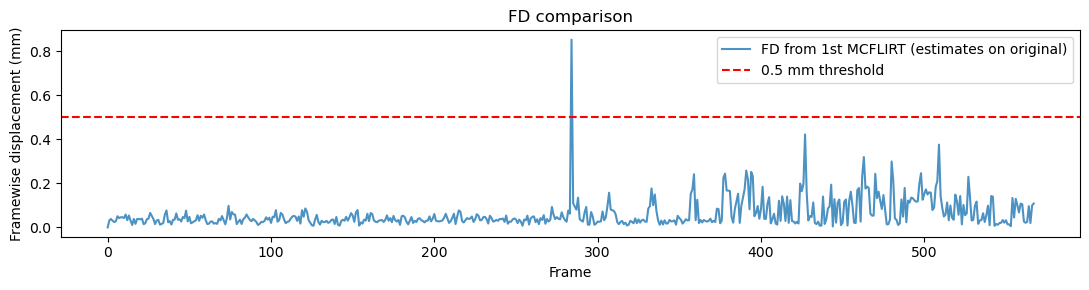

FD : mean=0.060 mm, max=0.853 mm


In [6]:
def compute_fd_from_par(par_file, radius_mm=50.0):
    """
    par_file columns: rot_x, rot_y, rot_z (radians), trans_x, trans_y, trans_z (mm)
    Convert rotations to mm using a head radius, then sum absolute diffs across 6 params.
    Returns: FD array (n_volumes,)
    """
    mp = np.loadtxt(par_file)
    if mp.ndim == 1:
        mp = mp[None, :]  # handle single-row edge case
    rot = mp[:, :3] * radius_mm           # radians -> mm
    trans = mp[:, 3:]
    six = np.hstack([rot, trans])         # shape (T, 6)
    diff = np.vstack([np.zeros((1, 6)), np.diff(six, axis=0)])
    return np.sum(np.abs(diff), axis=1)

moco_img = path_moco_data + '.nii.gz'
par_post = path_moco_data + '.par'

fd = compute_fd_from_par(par_post)

# Plot framewise displacement
plt.figure(figsize=(11,3))
plt.plot(fd, label='FD from 1st MCFLIRT (estimates on original)', alpha=0.8)
plt.axhline(0.5, ls='--', color='r', label='0.5 mm threshold')
plt.xlabel('Frame')
plt.ylabel('Framewise displacement (mm)')
plt.title('FD comparison')
plt.legend()
plt.tight_layout()
plt.show()

# Quick stats
print(f"FD : mean={fd.mean():.3f} mm, max={fd_after.max():.3f} mm")

#### Displaying the resulting motion corrected data

In [3]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(concat_tfMRI_data_path)
fsleyesDisplay.load(path_moco_data)


(ipykernel_launcher.py:20255): Gdk-WARNING **: 20:52:33.982: gdkdrawable-x11.c:952 drawable is not a pixmap or window


## 2.d : Gaussian smoothing

#### Aplying gaussian smoothing on the motion corrected data

In [8]:
from pathlib import Path

in_img = concat_tfMRI_data_path

# remove any previous partial file
try:
    Path(gaussian_filtered_path).unlink()
except FileNotFoundError:
    pass

img = nib.load(concat_tfMRI_data_path)
# voxel sizes in mm:
vx, vy, vz = img.header.get_zooms()[:3]
fwhm_mm = 6.0
sigma_vox = (fwhm_mm / 2.3548) / np.mean([vx, vy, vz])

subprocess.run(['fslmaths', in_img, '-s', str(sigma_vox), gaussian_filtered_path], check=True)


CompletedProcess(args=['fslmaths', '/home/jovyan/Labs/mydataset/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_scaled.nii.gz', '-s', '1.2739935450993716', '/home/jovyan/Labs/mydataset/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_bbr_smoothed-6mm.nii.gz'], returncode=0)

#### Displaying the resulting smoothed data

In [11]:
gaussian_filtered_path = op.join(preproc_func_path, 'sub-{}_task-motor_concat_bbr_smoothed-6mm.nii.gz'.format(subject_id))

fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(gaussian_filtered_path)
fsleyesDisplay.load(gaussian_filtered_path)

## 3 : GLM 

#### Preprocessing the event files

In [3]:
bids_func = op.join(bids_root, 'sub-101410', 'func')

# Read events
ev1 = pd.read_csv(op.join(bids_func, 'events_LR.csv'))
ev2 = pd.read_csv(op.join(bids_func, 'events_RL.csv'))

# Renaming contion to trial_type
ev1 = ev1.rename(columns={'condition': 'trial_type'})
ev2 = ev2.rename(columns={'condition': 'trial_type'})

# Compute time offset for run 2 from run 1 BOLD
run1_bold = op.join(bids_func, 'sub-101410_tfMRI_MOTOR_LR.nii')
run1_json = op.join(bids_func, 'task-motor_bold.json')

img = nib.load(run1_bold)
n_vols = img.shape[-1]

with open(run1_json) as f:
    meta = json.load(f)
TR = meta.get('RepetitionTime')  # in seconds

offset = n_vols * TR  # duration of run 1 in seconds

# Shift onsets for run 2
ev2['onset'] = ev2['onset'].astype(float) + float(offset)

# Concatenate, sort by time, and save
events = pd.concat([ev1, ev2], ignore_index=True)
events = events.sort_values('onset', kind='mergesort')  # stable sort
events.to_csv(op.join(bids_func, 'combined_events.tsv'), sep='\t', index=False)

#### Creating a first level design matrix

In [4]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=TR,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

#### Displaying the resulting design matrix

In [ ]:
# Fit the model to our design and data
fmri_glm = fmri_glm.fit(gaussian_filtered_path, events)

from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


#### Report the experimental design matrix to use for this subject, which you will be using in the following GLM analysis.


## 4 : GLM run
Run the GLM at the level you deem reasonable and report the statistical maps of
each of the task-related regressors. Briefly comment on the statistical maps and, if
you can, relate them to the corresponding task.

In [ ]:
# Fit the model to our design and data
fmri_glm = fmri_glm.fit(concat_tfMRI_data_path, events)

## 5 : Hand motion vs feet motion activation map
Using the results of the GLM analysis and a contrast vector of your choice, create the
activation maps corresponding to the hand motion against feet motion. Please
include in the report the contrast vector used and the contrast map you obtained.


<Axes: label='conditions'>

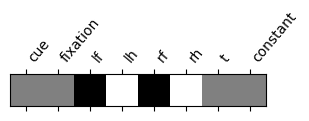

In [34]:
# Create the dictionary of the conditions
conditions = {
    'hand_motion': np.array([0, 0, 0, 1, 0, 1, 0, 0]),
    'feet_motion':np.array([0, 0, 1, 0, 1, 0, 0, 0])
}

hand_mot_vs_feet_mot = conditions['hand_motion'] - conditions['feet_motion']

from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(hand_mot_vs_feet_mot, design_matrix=fmri_glm.design_matrices_[0])

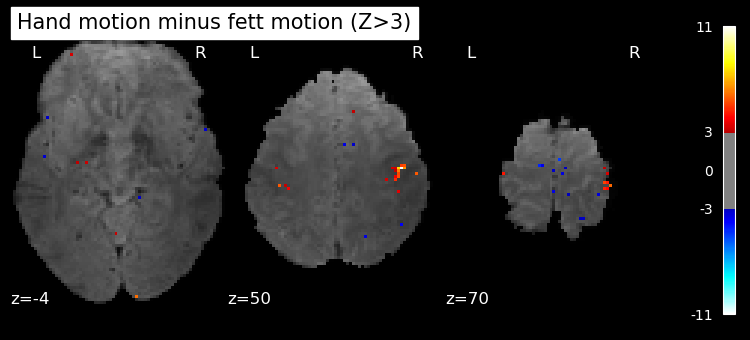

In [35]:
z_map = fmri_glm.compute_contrast(hand_mot_vs_feet_mot,
                                  output_type='z_score')
image_path = path_moco_data + ".nii.gz"

z_map_uncorrected_path = op.join(preproc_func_path, 'sub-{}_hand_mot_vs_feet_mot_z_map_uncorrected.nii.gz'.format(subject_id))
nib.save(z_map, z_map_uncorrected_path)

from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(image_path),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=3.0,
              display_mode='z', cut_coords=[-4,50,70], black_bg=True,
              title='Hand motion minus fett motion (Z>3)')

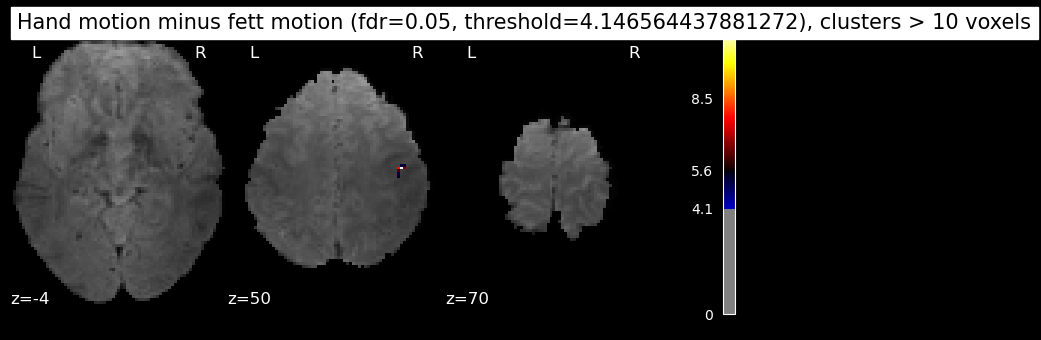

In [36]:
from nilearn.glm import threshold_stats_img

#Link to threshold_stats_img function documentation
#https://nilearn.github.io/dev/modules/generated/nilearn.glm.threshold_stats_img.html

cluster_size = 3 # Nmber of voxels for a cluster to be kept
fdr_rate = 0.01 # fdr rate to use!

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

# And this is just to plot here!
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=[-4,50,70], black_bg=True,
              title='Hand motion minus fett motion (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load('localizer_population_cleaned_map.nii.gz')

## 6 : Contrast map and AAL atlas parcellation overlay
To better interpret your results, overlay the contrast map with the AAL atlas
parcellation (hint: take a look at NiLearn). Report in which brain regions you find
maximal contrast. (Note: the functional data are already in MNI space, so there is no
need to do coregistration and normalization!)

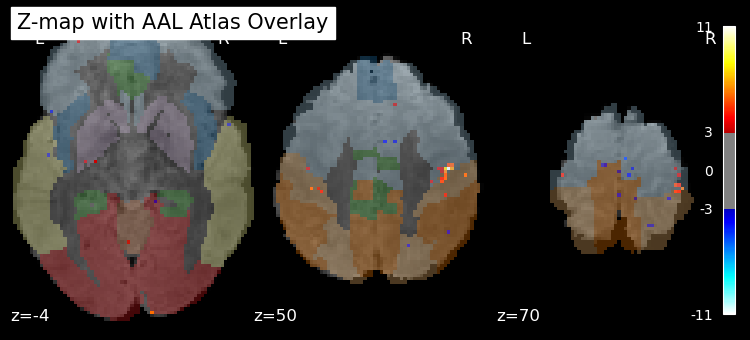

In [37]:
from nilearn import image,plotting,datasets
aal=datasets.fetch_atlas_aal(version='SPM12')
atlas_img=aal.maps 

display = plotting.plot_stat_map(z_map,bg_img=mean_img_[0],threshold=3.0,display_mode='z',cut_coords=[-4,50,70],black_bg=True,title='Z-map with AAL Atlas Overlay'
)

# Overlay the colored atlas with transparency
display.add_overlay(
    atlas_img,
    cmap='Paired',   # you can change to 'Paired', 'tab10', etc.
    alpha=0.3       # transparency of the atlas
)

plotting.show()

# Practicals part 2 - KMeans clustering

1. Apply K-means clustering on the subject fMRI runs, considering one volume as one
sample.
2. Select a number of clusters of your choice to keep while providing a justification for
your choice. Show each of the centroids separately overlaid on the anatomy, in axial
view only.
3. Compute the pairwise similarity (using a similarity measure of your choice) of the first
5 (independently on the choice you made on point 2) obtained centroids. Report the
similarity matrix.

## 1 : Data loading and Preprocessing

In [2]:
data_for_KMeans_path = gaussian_filtered_path
img = nib.load(op.join(data_for_KMeans_path))
affine = img.affine
data = np.asanyarray(img.dataobj)

mask_data_for_KMeans_path = path_moco_data+'.nii.gz'
mask_img = nib.load(op.join(mask_data_for_KMeans_path))
mask_affine = img.affine
mask_data = np.asanyarray(img.dataobj)

vol_shape = data.shape[:3]
n_vols = data.shape[3]

# Background (encoded as 0) removal
first_volume = mask_data[:,:,:,0]
mask_non_background = first_volume > 1.5
# Vectorize : Taking only non-zero voxels into a vector 
samples = data[mask_non_background, :]

# Calculate the mean of voxels for each timepoint
spatial_means = np.mean(samples, axis=0)
# Subtracting the mean to all voxels for each timepoint
row_means = np.tile(spatial_means, (samples.shape[0], 1))
X = samples - row_means

(91, 109, 91)


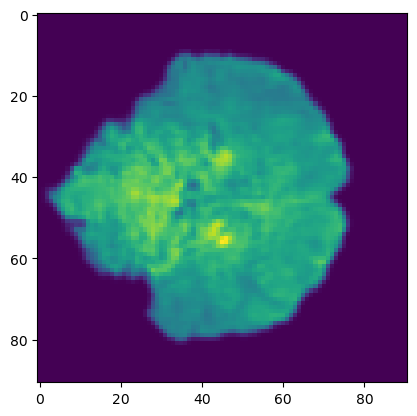

In [4]:
print(first_volume.shape)
plt.imshow(first_volume[:,45,:])

(91, 109, 91)


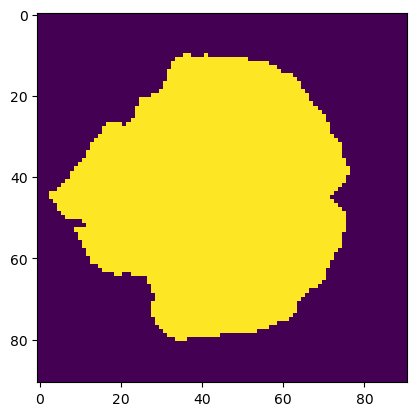

In [5]:
print(mask_non_background.shape)
plt.imshow(mask_non_background[:,45,:])

## 2 : Applying KMeans

#### Testing resulting inertia for different numbers of clusters

In [6]:
from sklearn.cluster import KMeans
from tqdm import tqdm

# Computing the inertia (average distance between samples and their respective clusters) for different numbers of clusters
max_nb_clusters = 5
inertia = []
for nb_cluster in tqdm(range(1, max_nb_clusters+1)):
    kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_init="auto").fit(X.T) # X.T is of shape (n_timepoints, n_voxels) i.e. (n_samples, n_features) 
    inertia.append(kmeans.inertia_)

100% 4/4 [00:16<00:00,  4.05s/it]


#### Displaying the inertia per cluster number

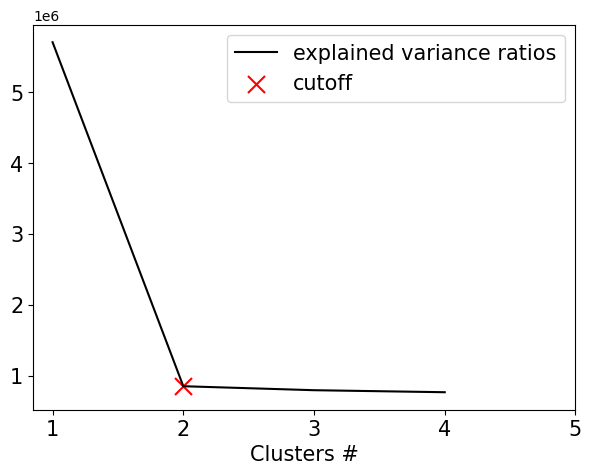

In [9]:
fig, ax = plt.subplots(1, figsize=(7,5))

nb_clusters = 2

ax.plot(np.arange(1, len(inertia)+1), inertia, label='explained variance ratios', c='k')
ax.scatter([nb_clusters], [inertia[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax.set_xlabel('Clusters #', size=15)
ax.legend(prop={'size':15})
plt.xticks(range(1,max_nb_clusters+1))
ax.tick_params(axis='both', which='major', labelsize=15)

#### Applying KMeans with the determined number of clusters and building mean spatial patterns

In [6]:
from sklearn.cluster import KMeans
nb_clusters = 2

# The number of clusters is to be determined from the last graph

kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_init="auto").fit(X.T)

# One label per time point
time_labels = kmeans.labels_  # shape: (n_timepoints,)

# Build a mean spatial pattern for each state (average the volumes in that state)
kmeans_clusters = []  # one 3D volume per state (mean pattern)
for c in range(nb_clusters):
    idx = (time_labels == c)
    # Mean across selected timepoints -> vector (n_voxels,)
    mean_pattern = X[:, idx].mean(axis=1)
    vol = np.zeros(mask_non_background.shape)
    vol[mask_non_background] = mean_pattern
    kmeans_clusters.append(vol)

#### Displaying the resulting temporal states

In [ ]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(img)
visual_idx = 0
plot_stat_map(nib.Nifti1Image(kmeans_clusters[visual_idx], affine), bg_img=mean_img_, threshold=0,
               cut_coords=[49,37,00], black_bg=True,
              title=f'K-means Cluster {visual_idx}')

plt.show()
visual_idx = 1
plot_stat_map(nib.Nifti1Image(kmeans_clusters[visual_idx], affine), bg_img=mean_img_, threshold=0,
               cut_coords=[49,37,00], black_bg=True,
              title=f'K-means Cluster {visual_idx}')

plt.show()